In [59]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from gwent_cards_dict import *
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
warnings.filterwarnings('ignore')  # не запускать когда проверяю на ошибки, а когда знаю что будет ошибка, но не засорять чат

In [2]:
class MyAgent(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.dtype = torch.float64
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.input_dim = input_dim # 360, 120x3
        self.hidden_dim = 1024
        self.output_dim = output_dim

        self.lin1 = nn.Linear(self.input_dim, self.hidden_dim, device=self.device, dtype=self.dtype)
        self.lin2 = nn.Linear(self.hidden_dim, self.hidden_dim, device=self.device, dtype=self.dtype)
        self.lin3 = nn.Linear(self.hidden_dim, self.output_dim, device=self.device, dtype=self.dtype)

        self.func = nn.ReLU() 

    def forward(self, x):
        out = self.func(self.lin1(x))
        out = self.func(self.lin2(out))
        out = self.func(self.lin3(out))
        return out
    

def data_to_tensor(data, dtype, device=None):
    if not device:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    return torch.tensor(data, dtype=dtype, device=device)

In [3]:
class Card:
    def __init__(self, ids: int, power: int, line_type: int, is_ability: bool, index_ability: int, card_type: int):
        self.id = ids
        self.power = power
        self.line_type = line_type
        self.is_ability = is_ability
        self.index_ability = index_ability
        self.card_type = card_type

In [4]:
# Бито
class Cards_Beatten:
    '''
    Будет сборником карт, побитых игроками карт, для того
    чтобы вытаскивать отсюда карты специальными способностями.ы
    ''' 
    def __init__(self, check=False):
        self.beatten = np.array([])
        self.check = check

    
    def get_beatten_card(self, cards):
        if isinstance(cards, (list, np.ndarray)):
            for card in cards:
                self.beatten = np.append(self.beatten, cards)
            if self.check:
                print('В бито были отправлены карты ', [card.id for card in cards])
        else:
            self.beatten = np.append(self.beatten, cards)
            if self.check:
                print('В бито была отправлены карта ', cards.id)
        # self.beatten.append(card)


    def return_beatten_card(self, card):
        # self.beatten.remove(card)
        if self.check:
                print('Из бито была получена карта ', card.id)
        pass

In [23]:
class Line: 
    def __init__(self, line_type: int, cards_beatten: Cards_Beatten):
        self.power_num = 0
        self.int_dtype = np.int64
        
        self.beatten = cards_beatten
        self.line_type = line_type
        self.power_base = np.array([]) # non-hero
        self.power_transformed = np.array([]) # non-hero
        self.power_base_hero = np.array([]) # hero
        
        self.transform_list = np.array([])
        self.cards_store_id = np.array([], dtype=self.int_dtype) # содержит id карточек 
        self.cards_store = np.array([]) # карточки класса Card
        
        self.cards_store_id_hero = np.array([], dtype=self.int_dtype) # содержит id карточек Hero 
        self.cards_store_hero = np.array([]) # карточки класса Card Hero
        

    # прописать и добавление карточек, а не только самих id
    def add_card(self, card: Card):
        '''
        Одна из самых главных функций в будущем - обработчик карт при их поступлении.
        Здесь нужно будет реализовать выбор дальнейших действий: использование способности, влияние погоды, ... 
        '''
        if card.card_type == 0:
            self.cards_store_id, self.cards_store, self.power_base = self.stores_update(self.cards_store_id, 
                                                                                        self.cards_store, 
                                                                                        self.power_base, 
                                                                                        card)
            # продумать логику, что раньше чего
            # добавление трансформации в self.transform_list - тут
            self.rebuild_transformed_power()
            
        elif card.card_type == 1:
            self.cards_store_id_hero, self.cards_store_hero, self.power_base_hero = self.stores_update(self.cards_store_id_hero, 
                                                                                                       self.cards_store_hero,
                                                                                                       self.power_base_hero, 
                                                                                                       card)

        self.recount_power()

    def stores_update(self, cards_store_id, cards_store, power_base, card):
        cards_store_id = np.append(cards_store_id, card.id)
        cards_store = np.append(cards_store, card)
        power_base = np.append(power_base, card.power)
        return cards_store_id, cards_store, power_base

    # возможно придется переделать под будущую логику
    # def add_transformation(self, transformation):
        # self.transform_list = np.append(self.transform_list, transformation)
    
    def to_one_transformation(self, array: np.array):
        return np.ones(shape=len(array))

    def plus_one_transformation(self, array: np.array):
        return array + 1

    def multi_by_two_transformation(self, array: np.array):
        return array * 2
    
    def rebuild_transformed_power(self):
        copy = True
        self.power_transformed = np.array(self.power_base, copy=copy)
        for transformation in self.transform_list:
            self.power_transformed = transformation(self.power_transformed)
    
    def recount_power(self):
        self.power_num = np.sum(self.power_transformed)
        self.power_num += np.sum(self.power_base_hero)

    
    def remove_card(self, cards: list[Card]): 
        # мб придется убирать несколько карточек
        # self.power_num -= card.power
        if len(cards) != 0:
            if isinstance(cards, (list, np.ndarray)):
                cards = np.array([card.id for card in cards]) # list[id]
            else:
                cards = np.array([cards.id])
            indexes = np.where(self.cards_store_id.reshape(-1, 1) == cards.reshape(1, -1))[0]
            mask = np.zeros(shape=len(self.cards_store_id))
            mask[indexes] = 1
            
            cards_to_remove = self.cards_store[mask == 1] # карты, которые убираем
            self.cards_store_id = self.cards_store_id[mask == 0] # id тех карт, которые оставляем
            self.cards_store = self.cards_store[mask == 0] # карты, которые оставляем
            self.power_base = self.power_base[mask == 0]
            self.beatten.get_beatten_card(cards=cards_to_remove)
            # здесь еще надо будет добавить функцию изменения трансформации массива
            self.rebuild_transformed_power()
            self.recount_power()

    # используется для построения эмбеддингов, аккуратно с переписыванием
    def get_info(self):
        return self.power_num, self.cards_store_id, self.cards_store_id_hero

In [45]:
class Master_Lines:
    def __init__(self, lines: list[Line], enemy_lines: list[Line], cards_beatten: Cards_Beatten, check=False):
        self.lines = lines
        self.enemy_lines = enemy_lines
        self.abilities = [self.medic_ability, self.spy_ability, 
                          self.total_death_ability, self.line_death_ability] # доделывать список потихоньку
        self.dummy_abilities = [self.dummy_ability]*1000
        self.abilities += self.dummy_abilities
        self.beatten = cards_beatten
        self.check = check
        self.dtype_int = np.int64

    
    def link_to_stack(self, cards_stack):
        self.cards_stack = cards_stack

    
    def link_to_agent(self, agent, agent_num):
        self.agent = agent
        self.agent_num = agent_num
        self.give_agent_start_cards()

    
    def give_agent_start_cards(self):
        cards_to_give = self.cards_stack.get_start_cards()
        self.agent.add_cards(cards_to_give)

    
    def add_card(self, card: Card):
        '''
        На будущее: прописать, что использование карточки с особенностью Muster не подтягивает карты из бито.
        Только из колоды.
        И другие такие нюансы.
        '''
        if card is None: # случай, когда карта не пришла -> их больше нет (потом подвязать со сдаться)
            return None
        # if card.card_type == 0 or card.card_type == 1 or : # unit or hero, странная строка. зачем я ее делал? все типы нужно обрабатывать
        if card.is_ability == 1:
            if card.index_ability != 125: # если == 125, то способности еще не дописаны, их нет в self.abilities
                ability = self.abilities[card.index_ability - 1] # medic = 1 -> self.abilities[index_ability - 1]
                ability(card)            
        if self.check:
            print([card.id for card in self.agent.cards_in_hands], 'Состояние карточек у агента ' + str(self.agent_num), sep='\n')
            print(card.id, 'ID полученной карты для агента ' + str(self.agent_num), sep='\n')
        self.send_card(card)



    def send_card(self, card):
        if card.index_ability == 2: # Spy - отправляется на вражескую линию
            self.enemy_lines[card.line_type - 1].add_card(card)
        elif card.index_ability == 3: # total_death - scorch - карта удаляется
            pass
        else:
            self.lines[card.line_type - 1].add_card(card)

    def dummy_ability(self, card):
        # затычка на время отстуствия в списках self.abilities всех абилок, чтобы не вызывалась ошибка list_index_out_range
        pass

    def medic_ability(self, card): # 0 index in self.abilities, value 1 
        '''
        Возврат карточки на поле боя из "Бито".
        Нельзя вернуть героя и нейтральные (погода, рог, пугало).

        Дополнительный выходные нейроны действий для агента.
        Выбор карточек из бито (уже не рандом)
        '''
        # как я получаю action? аргумент из ... нейронки
        # тут будет какой то обработчик, исходя из действия агента - какую карточку получить из бито.
        # пока что наивное предположение, что action и есть id. потом перепишем
        # card = self.get_card_from_beatten_by_id(action) 
        # self.add_card(card)
        if self.check:
            print('Сработала способность медика - unreleased')
        pass
        

    def get_card_from_beatten_by_id(self, action):
        # как-то обработать action от агента -> index
        # index = 0
        # self.beatten
        pass

    def spy_ability(self, card): # 1 index in self.abilities, value 2 by id
        num_cards_to_drop = 2
        cards_to_drop = self.cards_stack.get_n_cards_from_stack(num_cards_to_drop)
        if self.check:
            print('*'*15)
            print('Сработала способность шпион ' + str(card.id))
            print()
            print([card.id for card in self.agent.cards_in_hands], 'карты на руках')
            print([card.id for card in cards_to_drop], 'карты, выпавшие')
            print('*'*15)
        self.agent.add_cards(cards_to_drop)

    def find_and_remove_by_death(self, lines, highest_power_num):
        if not isinstance(lines, (list, np.ndarray)):
            lines = np.array([lines])
        num_lines = len(lines)
        dtype = object
        cards_deleted = np.array([], dtype=dtype)
        for i in range(num_lines):
            indixes = np.where(lines[i].power_transformed == highest_power_num)[0]
            indixes = indixes.astype(self.dtype_int) # для того, чтобы даже пустой массив индексов имел тип int, чтобы можно было брать срез
            cards = lines[i].cards_store[indixes]
            cards_deleted = np.concatenate((cards_deleted, cards))
            lines[i].remove_card(cards)
        return cards_deleted


    def print_death_message(self, card, empty, cards_deleted=[]):
        print('*'*15)
        if card.id == 149: # total_scorch
            print('Сработала способность Scorch - total death ' + str(card.id))
            if empty:
                print('Поля - пустые. Удалять нечего')
            else:
                print('Были удалены карты:')
                print([card.id for card in cards_deleted])
        else:
            print('Сработала способность Scorch - на линию ' + str(card.line_type) + ', id карты ', str(card.id))
            if empty:
                print('Поля - пустые. Удалять нечего')
            else:
                print('Были удалены карты:')
                print([card.id for card in cards_deleted])
        print('*'*15)
        
    
    def total_death_ability(self, card): # 2 index in self.abilities, value 3 by id
        lines_my_total_power = np.concatenate([np.array(self.lines[i].power_transformed) for i in range(3)])
        lines_enemy_total_power = np.concatenate([np.array(self.enemy_lines[i].power_transformed) for i in range(3)])
        if len(lines_my_total_power) + len(lines_enemy_total_power) == 0:
            if self.check:
                self.print_death_message(card, empty=True)
            return None
        highest_power_num = np.max(np.concatenate((lines_my_total_power, lines_enemy_total_power)))            
        my_cards_deleted = self.find_and_remove_by_death(self.lines, highest_power_num)
        enemy_cards_deleted = self.find_and_remove_by_death(self.enemy_lines, highest_power_num)
        cards_deleted = np.concatenate((my_cards_deleted, enemy_cards_deleted))
        if self.check:
            self.print_death_message(card, empty=False, cards_deleted=cards_deleted)

    
    def line_death_ability(self, card): # 3 index in self.abilities, value 4 by id 
        lines_enemy_total_power = np.array(self.enemy_lines[card.line_type - 1].power_transformed)
        if len(lines_enemy_total_power) == 0:
            if self.check:
                self.print_death_message(card, empty=True)
            return None
        highest_power_num = np.max(lines_enemy_total_power)            
        enemy_cards_deleted = self.find_and_remove_by_death(self.enemy_lines[card.line_type - 1], highest_power_num)
        if self.check:
            self.print_death_message(card, empty=False, cards_deleted=enemy_cards_deleted)
            

In [7]:
class Agent:
    def __init__(self, master_lines: Master_Lines, shape: int, agent_num, check=False):
        self.cards_in_hands = []
        self.master_lines = master_lines
        self.shape = shape
        self.check = check
        self.agent_num = agent_num
        
    # добавление карт в колоду
    def add_cards(self, cards): # приходит либо массив карточек, либо карточки (вроде соло-карточек не осталось, но проверку пока оставим)
        if isinstance(cards, Card):
            self.cards_in_hands.append(cards)
            if self.check:
                print('Были добавлена карточка ', cards.id)
                print([card.id for card in self.cards_in_hands])
        elif isinstance(cards, list):
            for i in range(len(cards)):
                self.cards_in_hands.append(cards[i])
            if self.check:
                print('Были добавленые карточки ', [card.id for card in cards])
                print([card.id for card in self.cards_in_hands])


    def get_index_by_card_id(self, card_id: int):
        for index, card in enumerate(self.cards_in_hands):
            if card.id == card_id:
                return index
        return None


    def choose_card(self, card_id: int) -> bool: # случайный выбор карты для теста
        if len(self.cards_in_hands) != 0:
            size = 1
            card_id = card_id % self.shape # по количеству карт, 156 карт, от 1 до 156 включительно
            index = self.get_index_by_card_id(card_id)
            if index == None:
                return False
            chosen_card = self.cards_in_hands.pop(index)
            self.master_lines.add_card(chosen_card)
            if self.check:
                print(chosen_card.id, 'ID Выброшенной карты у агента ', self.agent_num, sep='\n')
            return True
        

    def choose_random_card(self) -> int: # случайный выбор карты для теста
        if len(self.cards_in_hands) != 0:
            size = 1
            index = np.random.randint(0, len(self.cards_in_hands), size=size)
            chosen_card = self.cards_in_hands.pop(index.item())
            self.master_lines.add_card(chosen_card)
            return chosen_card.id
        # len(self.cards_in_hands) == 0, карт нет, играть нечем, пасуем просто. это будет выбор 0 индекса
        return 0

    
    def get_observation(self) -> list[tuple[int, list[int]]]: 
        data = [self.master_lines.lines[i].get_info() for i in range(3)]
        if self.check == True:
            print(data, 'ID с первой по третью линию', sep = '\n')
        return data

In [8]:
# # test_block
# check = True
# check_ids = [4, 4, 4, 4, 4, 4, 4, 149]
# shape = 156 + 1
# card_stack_id = 1
# cs = Cards_Stack(card_stack_id, check, check_ids)
# beat1 = Cards_Beatten(check)
# beat2 = Cards_Beatten(check)
# lines1 = [Line(i, beat1) for i in range(1, 3 + 1)]
# lines2 = [Line(i, beat2) for i in range(1, 3 + 1)]
# master_lines1 = Master_Lines(lines1, lines2, beat1, check)
# master_lines2 = Master_Lines(lines2, lines1, beat2, check)
# agent = Agent(master_lines1, shape, 1, check)

# master_lines1.link_to_stack(cs)
# master_lines1.link_to_agent(agent, 1)
# print([card.id for card in cs.cards_stack])

In [32]:
# Колода # генератор кард
class Cards_Stack: 
    '''
    Генерирует колоду карт.
    Выдает карты при начале игры. done
    По случаю (использование спец. карт) выдает новые карты владельцу колоды. to-do
    (изначально колода сгенерирована случайно, значит, выдавать можно по порядку)
    '''
    def __init__(self, card_stack_id: int, check=False, check_ids=None):
        '''
        check - True, если проверяем, что происходит в колоде.
        check_ids - None, либо массив ID карточек для проверки. Выдаст именно его 
        (без зануления в остальной колоде, т.е., их же можно будет получить еще раз)
        '''
        self.num_cards_in_hands = 8
        self.card_stack_id = card_stack_id
        self.size = 30
        self.check = check
        self.check_ids = check_ids
        
        self.cards_stack, self.cards_dict = self.generate_card_stack() # list[Card], массив карточек, возможных за данную масть
        self.cards_indexes = np.arange(0, len(self.cards_stack)) # массив индексов карточек, где любой элемент - индекс для массива cards_stack, либо -1 если нет карточки
        

    
    def get_n_cards_from_stack(self, n: int): # получение n случайных карт из колоды
        available_indexes = np.where(self.cards_indexes > -1)[0]
        if len(available_indexes) != 0: # карты закончились
            indexes_to_choose_cards = np.random.randint(0, len(available_indexes), size=n)
            chosen_indexes = available_indexes[indexes_to_choose_cards]
            self.cards_indexes[chosen_indexes] = -1
            chosen_cards = []
            for i in range(n):
                chosen_cards.append(self.cards_stack[chosen_indexes[i]])
            return chosen_cards
        return []

    
    def get_n_cards_from_check_ids(self): # получение self.check_ids определенных карт, с возвращением в колоду (если по теории множеств и вероятности)
        chosen_cards = []
        for i in range(len(self.check_ids)):
            chosen_cards.append(self.cards_dict[self.check_ids[i]])
        return chosen_cards

    
    def refresh_indexes(self):
        self.cards_indexes = np.arange(0, len(self.cards_stack))

    
    # получение стартовой колоды
    def get_start_cards(self) -> list[Card]:
        # случайные self.num_cards_in_hands карточек
        if self.check_ids is not None:
            cards_in_hands = self.get_n_cards_from_check_ids() # получение карт через ID 
        else:
            cards_in_hands = self.get_n_cards_from_stack(self.num_cards_in_hands)
        if self.check:
            print([card.id for card in cards_in_hands], 'ID карт, полученных на руки при старте игры', sep='\n')
        return cards_in_hands


    # генерация колоды карт
    def generate_card_stack(self) -> list[Card]:
        cards = self.get_data_by_id() # id, power/strength, line_type/row, is_ability, ability_id, count
        cards_stack = []
        cards_dict = dict()
        for i in range(cards.shape[1]):
            for count in range(cards[6][i].item()): #!
                cards_stack.append(Card(cards[0][i], cards[1][i], cards[2][i], cards[3][i], cards[4][i], cards[5][i]))
            cards_dict[cards[0][i]] = Card(cards[0][i], cards[1][i], cards[2][i], cards[3][i], cards[4][i], cards[5][i])
        return cards_stack, cards_dict


    def get_data_by_id(self) -> np.array:
        if self.card_stack_id == 1:
            return self.generator_north_data()
        elif self.card_stack_id == 2:
            return self.generator_evil_data()
        elif self.card_stack_id == 3:
            return self.generator_skoyat_data()
        return self.generator_nilf_data()

    
    def generator_north_data(self) -> np.array:
        cards_north = np.array(self.parser_gwent_dict(gwent_cards_north))
        cards_neutral = np.array(self.parser_gwent_dict(gwent_cards_neutral))
        cards = np.concatenate((cards_north, cards_neutral), axis=1)
        return cards


    def generator_evil_data(self) -> np.array:
        cards_monsters = np.array(self.parser_gwent_dict(gwent_cards_monsters))
        cards_neutral = np.array(self.parser_gwent_dict(gwent_cards_neutral))
        cards = np.concatenate((cards_monsters, cards_neutral), axis=1)
        return cards


    def generator_skoyat_data(self) -> np.array:
        cards_skot = np.array(self.parser_gwent_dict(gwent_cards_skot))
        cards_neutral = np.array(self.parser_gwent_dict(gwent_cards_neutral))
        cards = np.concatenate((cards_skot, cards_neutral), axis=1)
        return cards


    def generator_nilf_data(self) -> np.array:
        cards_nilfgaard = np.array(self.parser_gwent_dict(gwent_cards_nilfgaard))
        cards_neutral = np.array(self.parser_gwent_dict(gwent_cards_neutral))
        cards = np.concatenate((cards_nilfgaard, cards_neutral), axis=1)
        return cards

    def row_to_line_type(self, row: str):
        if row == 'Close Combat':
            return 1
        elif row == 'Ranged Combat':
            return 2
        else:
            return 3 # siege


    def check_if_is_ability(self, ability: str):
        return 0 if len(ability) == 0 else 1

    
    def get_card_type(self, card_type: str):
        if card_type == 'Unit':
            return 0
        elif card_type == 'Hero':
            return 1
        elif card_type == 'Special':
            return 2

    
    def get_ability_id(self, ability: str):
        if 'Medic' in ability:
            return 1
        elif 'Spy' in ability:
            return 2
        elif 'Scorch - ' in ability: # line_scorch: villetretenmort, ... 
            return 4
        elif 'Scorch' in ability: # scorch_total
            return 3
        else:
            return 125 # пока что все остальное тут из способностей. в parser_gwent_dict по умолчанию 0, если способности нет
            

    def parser_gwent_dict(self, dct: dict[dict]):
        # id, power/strength, line_type/row, is_ability, ability_id, count
        # ids = list(gwent_cards_north.keys())
        ids, power, line_type, is_ability, ability_id, card_types, count = [], [], [], [], [], [], []
        for key in dct:
            card_type = dct[key]['type']
            if card_type == 'Unit' or card_type == 'Hero': # у любого Unit есть сила (герои сюда пока не входят). С leader, Weather и прочим проверять
                ids, power, line_type, is_ability, ability_id, card_types, count = self.fill_card_info(dct, key, ids, power, line_type, is_ability, ability_id, card_types, count)
            elif card_type == 'leader': # мб просто забить
                pass
            elif card_type == 'Weather':
                pass
            elif card_type == 'Special': # казнь, пугало, команд. рог - основные ( из дополнений плотва, корова, мб еще что то )
                # пока реализована только казнь
                if dct[key]['name'] == 'Scorch':
                    ids, power, line_type, is_ability, ability_id, card_types, count = self.fill_card_info(dct, key, ids, power, line_type, is_ability, ability_id, card_types, count)
                pass
        return [ids, power, line_type, is_ability, ability_id, card_types, count]

    
    def fill_card_info(self, dct, key, ids, power, line_type, is_ability, ability_id, card_types, count):
        ids.append(key)
        card_types.append(self.get_card_type(dct[key]['type']))
        power.append(dct[key]['strength'])
        line_type.append(self.row_to_line_type(dct[key]['row']))
        is_ability_value = self.check_if_is_ability(dct[key]['ability'])
        is_ability.append(is_ability_value)
        ability_id_value = 0
        
        if is_ability_value == 1:
            ability_id_value = self.get_ability_id(dct[key]['ability'])
            
        ability_id.append(ability_id_value)
        count.append(dct[key]['count'])
        return ids, power, line_type, is_ability, ability_id, card_types, count

In [10]:
class Game(): # матч 
    def __init__(self, check=False):

        self.dtype_float = torch.float64
        self.dtype_int = torch.int64
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.shape = 156 + 1 # 156 - последний уникальный id карточки. (от 1 до 156)
        self.lr = 3e-4
        self.check = check
        
        self.emb = Embeddings(shape=self.shape)
        self.input_dim = self.shape * 3 # отработать по размерност эмбеддинга, все карточки противника + все свои + свои в руках
        self.output_dim = self.shape # 
        self.model = MyAgent(input_dim=self.input_dim, output_dim=self.output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        
        # Память
        self.memory_states = []
        self.memory_actions = []
        self.memory_rewards = []
        self.memory_next_states = []
        self.memory_isdones = []
        # self.memory_len = 0 #? пока не нужно, т.к. длина партии константа у меня
        self.loses = []
        self.rewards_per_epoch = []

        
    def decide_who_first_to_step(self) -> int:
        return 2 if np.random.rand(1).item() > 0.5 else 1

    
    def decide_winner(self) -> int:
        sum1 = np.sum([self.lines1[i].power_num for i in range(3)])
        sum2 = np.sum([self.lines2[i].power_num for i in range(3)])
        return 1 if sum1 > sum2 else 2
        

    def get_observation_data(self) -> tuple[list, list, list]:
        data1 = self.agent1.get_observation() # узнать, что на столе у 1ого агента
        data2 = self.agent2.get_observation() # узнать, что на столе у 2ого агента
        data_cards_in_hands = self.agent1.cards_in_hands 
        return data1, data2, data_cards_in_hands


    def remember(self, state: torch.Tensor,
                action: int, 
                reward: int, 
                next_state: torch.Tensor, 
                isDone: bool):
        self.memory_states.append(state)
        self.memory_actions.append(action)
        self.memory_rewards.append(reward)
        self.memory_next_states.append(next_state)
        self.memory_isdones.append(1 - isDone)
        # self.memory_len += 1 # пока не нужно


    def samplebatch(self):
        memory_states = torch.tensor(np.array(self.memory_states), dtype=self.dtype_float, device=self.device)
        memory_actions = torch.tensor(np.array(self.memory_actions), dtype=self.dtype_int, device=self.device)
        memory_rewards = torch.tensor(np.array(self.memory_rewards), dtype=self.dtype_float, device=self.device)
        memory_next_states = torch.tensor(np.array(self.memory_next_states), dtype=self.dtype_float, device=self.device)
        memory_isdones = torch.tensor(np.array(self.memory_isdones), dtype=self.dtype_float, device=self.device)
        
        # self.memory_len = 0 #? пока не нужно, т.к. длина партии константа у меня
        return memory_states, memory_actions, memory_rewards, memory_next_states, memory_isdones

    
    def clearbatch(self):
        self.memory_states.clear()
        self.memory_actions.clear()
        self.memory_rewards.clear()
        self.memory_next_states.clear()
        self.memory_isdones.clear()
        

    def reward(self, res: int, cards_in_hands_one_hot: torch.Tensor) -> int:
        if res == 0 and cards_in_hands_one_hot.sum()==0:
            # Спасовано грубо говоря, пока просто так оставим
            return -25 
        if cards_in_hands_one_hot[res] > 0:
            # print('Успешный ход')
            return 25
        else:
            # print('Была выбрана несуществующая карта')
            return -25


    def get_state(self) -> torch.Tensor:
        data1, data2, data_cards_in_hands = self.get_observation_data()
        state = self.emb.get_embeddings(data1, data2, data_cards_in_hands)
        state = data_to_tensor(state, dtype=self.dtype_float, device=self.device)
        return state


    # первый агент - обучаемый. второй - среда
    def session(self, episodes=10000, eps=0.3, 
                card_stack_id_1_check=None, 
                card_stack_id_2_check=None, 
                check_ids1=None, 
                check_ids2=None) -> tuple[list[int], int]:
        """
        """
        # # Чей первый ход
        # if self.decide_who_first_to_step() == 1:

        # Создание колод карт и начального набора
        self.card_stack1_1 = Cards_Stack(card_stack_id=1, check=self.check, check_ids=check_ids1) # северные королества, agent_1
        self.card_stack1_2 = Cards_Stack(card_stack_id=1, check=self.check, check_ids=check_ids2) # северные королества, agent_2
        self.card_stack2_1 = Cards_Stack(card_stack_id=2, check=self.check, check_ids=check_ids1) # монстры, agent_1
        self.card_stack2_2 = Cards_Stack(card_stack_id=2, check=self.check, check_ids=check_ids2) # монстры, agent_2
        self.card_stack3_1 = Cards_Stack(card_stack_id=3, check=self.check, check_ids=check_ids1) # скоятаэли, agent_1
        self.card_stack3_2 = Cards_Stack(card_stack_id=3, check=self.check, check_ids=check_ids2) # скоятаэли, agent_2
        self.card_stack4_1 = Cards_Stack(card_stack_id=4, check=self.check, check_ids=check_ids1) # нильфы, agent_1
        self.card_stack4_2 = Cards_Stack(card_stack_id=4, check=self.check, check_ids=check_ids2) # нильфы, agent_2
        
        self.card_stacks_1 = [self.card_stack1_1, self.card_stack2_1, self.card_stack3_1, self.card_stack4_1] # for agent1
        self.card_stacks_2 = [self.card_stack1_2, self.card_stack2_2, self.card_stack3_2, self.card_stack4_2] # for agent2
        winners = []
        size = 1
        length_of_games = []

        self.model.eval()
        for episode in range(episodes):
            # Создание полей игры, бито и обработчика карт, полей
            self.beatten1 = Cards_Beatten(check=self.check)
            self.beatten2 = Cards_Beatten(check=self.check)
            self.lines1 = [Line(i, self.beatten1) for i in range(1, 3 + 1)]
            self.lines2 = [Line(i, self.beatten2) for i in range(1, 3 + 1)]
            self.master_lines1 = Master_Lines(self.lines1, self.lines2, self.beatten1, self.check)
            self.master_lines2 = Master_Lines(self.lines2, self.lines1, self.beatten2, self.check)
            
            
            # Создание игроков, подключение обработчику карт агентов и колод карт
            card_stack_id_1 = np.random.randint(low=0, high=4, size=1).item()
            card_stack_id_2 = np.random.randint(low=0, high=4, size=1).item()
            if card_stack_id_1_check is not None: 
                card_stack_id_1 = card_stack_id_1_check - 1
            if card_stack_id_2_check is not None:
                card_stack_id_2 = card_stack_id_2_check - 1
            
            self.agent1 = Agent(master_lines=self.master_lines1, shape=self.shape, agent_num=1, check=self.check)
            self.agent2 = Agent(master_lines=self.master_lines2, shape=self.shape, agent_num=2, check=self.check)
            self.master_lines1.link_to_stack(self.card_stacks_1[card_stack_id_1])
            self.master_lines2.link_to_stack(self.card_stacks_2[card_stack_id_2])
            self.master_lines1.link_to_agent(self.agent1, 1) # присоединение к агенту + выдача стартового набора карточек
            self.master_lines2.link_to_agent(self.agent2, 2)
            
 
            length_of_game = 0
            state = self.get_state()
            isDone = False
            flag = False
            while len(self.agent1.cards_in_hands) > 0 or len(self.agent2.cards_in_hands) > 0:
                length_of_game += 1
                if np.random.rand(1).item() > eps:
                    # ход случайной картой из рукава (гарантированно)
                    flag=True
                else:
                    # обработка нейронкой
                    state = self.get_state()
                    answer = self.model(state)
                    action = answer.argmax().item()
                    
                # ходы агента и среды
                if flag == True:
                    # print('рандомный ход')
                    action = self.agent1.choose_random_card()
                    not_to_use = self.agent2.choose_random_card() # рандомный выбор от среды
                else:
                    # print('ход с просчетом нейронки')
                    is_success = self.agent1.choose_card(action)
                    if is_success is None or is_success == True: 
                        not_to_use = self.agent2.choose_random_card()
                
                flag = False
                reward_value = self.reward(action, state[2*self.shape:]) # расчет награды 
                # print(reward_value, len(self.agent2.cards_in_hands))
                
                next_state = self.get_state()
                
                if len(self.agent1.cards_in_hands) == 0 and len(self.agent2.cards_in_hands) == 0:
                    isDone = True # True если конец серии, в нашем случае пока просто когда длина массивов закончится
                self.remember(state, action, reward_value, next_state, isDone)
                
                state = next_state

            # выбранные cards_stacks должны быть обновлены
            self.card_stacks_1[card_stack_id_1].refresh_indexes()
            self.card_stacks_2[card_stack_id_2].refresh_indexes()

            # заполнение статистики
            winner_agent = self.decide_winner()
            winners.append(winner_agent)
            length_of_games.append(length_of_game)
            
        return length_of_games

    
    def prepare_train_target(self, 
                             rewards: torch.Tensor, 
                             actions: torch.Tensor, 
                             possible_actions_size: int) -> torch.Tensor:
        rewards = rewards.reshape(-1)
        size = rewards.shape[0]
        reward_matrix = torch.ones(size, size) + torch.tril(torch.ones(size, size)*-2, diagonal=-1)
        indixes = torch.where(rewards < 0)[0]
        reward_matrix[:, indixes] = -1
        reward_matrix = reward_matrix * 25
        
        target = torch.ones((size, possible_actions_size))*-25
        target[:, actions] = reward_matrix
        return torch.tensor(target, dtype=self.dtype_float, device=self.device)        
    
    def train_agent(self):
        self.model.train()
        states, actions, rewards, next_states, isdones = self.samplebatch() # все списки в torch.Tensor
        NeuroNowAnswer = self.model(states)
        target = self.prepare_train_target(rewards, actions, NeuroNowAnswer.shape[1])

        loss = self.criterion(target, NeuroNowAnswer)
        self.loses.append(loss.item())
        self.rewards_per_epoch.append(torch.sum(rewards).item())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.clearbatch()
        return self.loses, self.rewards_per_epoch, rewards.reshape(-1).shape[0]

    def play_and_train(self, episodes=10_000, eps=0.3, epochs=1, 
                       card_stack_id_1_check=None,
                       card_stack_id_2_check=None, 
                       check_ids1=None,
                       check_ids2=None):
        total_loss_per_epochs = []
        total_reward_per_epochs = []
        total_num_played_cards_per_epochs = []
        lengths = []
        for epoch in range(epochs):
            length_of_game = self.session(episodes=episodes, eps=0.3, 
                                          card_stack_id_1_check=card_stack_id_1_check,
                                          card_stack_id_2_check=card_stack_id_2_check, 
                                          check_ids1=check_ids1,
                                          check_ids2=check_ids2)
            lengths.append(length_of_game)
            loss, reward, num_played_cards = self.train_agent()
            total_loss_per_epochs.append(loss)
            total_reward_per_epochs.append(reward)
            total_num_played_cards_per_epochs.append(num_played_cards)
        return np.array(total_loss_per_epochs), np.array(total_reward_per_epochs), np.array(total_num_played_cards_per_epochs), lengths

In [11]:
class Embeddings:
    '''
    Класс, который получает на вход данные с обсервации и переделывает их 
    в вектор для поступления в нейронную сеть.
    '''
    def __init__(self, shape=120):
        self.shape = shape 

    
    def get_embeddings(self, 
                       data_agent1: list[tuple[int, list[int], list[int]]], 
                       data_agent2: list[tuple[int, list[int], list[int]]], 
                       data_cards_in_hands: list[Card]) -> np.array:
        embed1 = self.one_hot_to_vector(data_agent1)
        embed2 = self.one_hot_to_vector(data_agent2)
        embed3 = self.cards_in_hands_to_vector(data_cards_in_hands)
        return np.concatenate((embed1, embed2, embed3))
        
    
    def one_hot_to_vector(self, data: list[tuple[int, list[int]]]) -> np.array:
        arr = np.zeros(shape=self.shape)
        for i in range(len(data)):
            arr += self.store_to_one_hot(data[i][1]) # non-hero
            arr += self.store_to_one_hot(data[i][2]) # hero
        return arr

    
    def store_to_one_hot(self, store: list[int]) -> np.array:
        arr = np.zeros(shape=self.shape)
        store = np.array(store)
        if len(store) > 0:
            arr[np.unique(store, return_counts=True)[0]] = np.unique(store, return_counts=True)[1]
        return arr
    

    def cards_in_hands_to_vector(self, cards: list[Card]) -> np.array:
        arr = np.zeros(shape=self.shape)
        for card in cards:
            arr[card.id] += 1
        return arr

In [82]:
%%time
check=False # проверка выброса карт
card_stack_id_1_check=3
card_stack_id_2_check=3
check_ids1=[128, 128, 128, 128, 128, 128, 128, 128]
check_ids2=[128, 128, 128, 128, 128, 128, 128, 128] # переписать, чтобы при выдаче  этих ID выдавало именно эти карточки с этими ID.
# А он берет из базы, где это индексы, и с учетом повторов они сдвигаются.
# доработать саму способность шпиона. кажется, он добавляет в разные массивы... или везет


card_stack_id_1_check = None
card_stack_id_2_check = None
check_ids1 = None
check_ids2 = None
g = Game(check=check)
episodes = 5
epochs = 100
eps = 0.3
total_loss, total_reward_per_epoch, total_num_played_cards_per_epochs, lengths = g.play_and_train(episodes=episodes, eps=eps, epochs=epochs, 
                                                                                                  card_stack_id_1_check=card_stack_id_1_check,
                                                                                                  card_stack_id_2_check=card_stack_id_2_check,
                                                                                                  check_ids1=check_ids1,
                                                                                                  check_ids2=check_ids2)

CPU times: total: 22 s
Wall time: 11.6 s


In [81]:
# g.card_stack1_1.__dict__
# g.__dict__['beatten2'].__dict__['beatten']

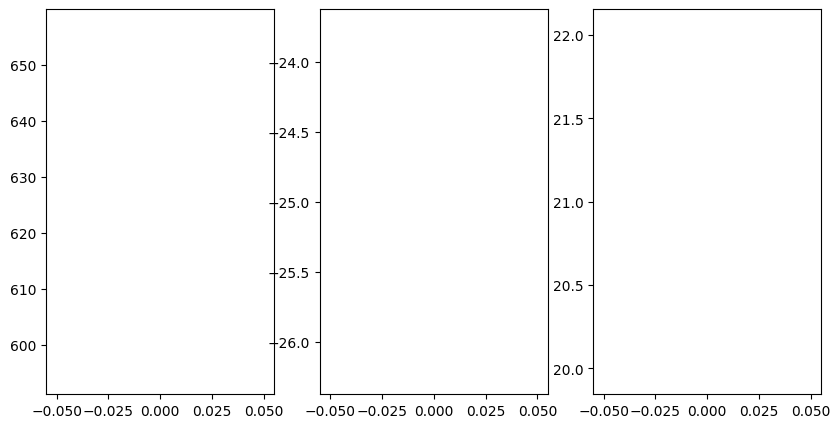

In [63]:
def get_lineplot(loss, reward, num_cards):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    cont = [np.array(np.mean(loss, axis=0)), 
            np.array(np.mean(reward, axis=0)), 
            np.array(num_cards)]
    for i in range(3):
        sns.lineplot(data=cont[i], ax=axes[i])
    # plt.show()
        
get_lineplot(total_loss, total_reward_per_epoch, total_num_played_cards_per_epochs)

In [15]:
# допилить норм тест
def test_trained_against_not(g: Game):
    g1 = Game()
    ln1s, ln2s = [], []
    for i in range(20):
        ln1 = g.session(episodes=1, eps=0.9) # обучен
        ln2 = g1.session(episodes=1, eps=0.9) # не обучен
        ln1s.append(ln1)
        ln2s.append(ln2)
    return np.array([ln1s, ln2s]).reshape(2, -1)

In [ ]:
res = test_trained_against_not(g)
res